# Clip Guidance gradient

Because the guidance gradient scales linearly with the $\beta$ and a higher beta leads to smaller sampling regions it would be beneficial to use higher and higher beta values. 
$$\nabla_\theta \log(p(\theta_t|x)) = \nabla_x \log(p(\theta_t)) + \nabla_x \log(p(x | \theta_t))
$$
with 
$$
\nabla_x \log(p(x | \theta_t)) = - \beta q_\psi(\theta_t, x, t)$$
where $q_\psi(\theta_t, x, t)$ is the guidance model which approximates $d(x, x_T) = || x - x_T||^2_2$

Unfortunately we observe a disturbance (no clear modes but a huge scatter) while using high values of beta like 10_000. We assume the gradient is not as informative as it could / should be and introduces a numerical instability. Therefor we propose to clip the gradient in the sampling process to get a more stable gradient for guidance

In [1]:
from pathlib import Path

import numpy as np
import torch
from torch import Tensor
from tqdm import tqdm

from gbi_diff.model.lit_module import DiffusionModel, Guidance
from gbi_diff.sampling.utils import get_sample_path, load_observed_data
from gbi_diff.utils.plot import _pair_plot
from gbi_diff.utils.sampling_diffusion_config import Config
from gbi_diff.utils.train_diffusion_config import Config as DiffusionConfig
from gbi_diff.utils.train_guidance_config import Config as GuidanceConfig
import matplotlib.pyplot as plt

In [2]:
class DiffusionSampler:
    def __init__(
        self,
        diff_model_ckpt: str | Path,
        guidance_model_ckpt: str | Path,
        config: Config,
        grad_clipping: float = None,
        *args,
        **kwargs,
    ):
        super().__init__(*args, **kwargs)
        if isinstance(diff_model_ckpt, str):
            diff_model_ckpt = Path(diff_model_ckpt)
        self.diff_model_ckpt = diff_model_ckpt
        if isinstance(guidance_model_ckpt, str):
            guidance_model_ckpt = Path(guidance_model_ckpt)
        self.guidance_model_ckpt = guidance_model_ckpt

        self._check_model_compatibility(diff_model_ckpt, guidance_model_ckpt)
        self._check_config(config.observed_data_file, guidance_model_ckpt)

        self._config = config
        self._beta = self._config.beta
        self._guidance_model = Guidance.load_from_checkpoint(guidance_model_ckpt)
        self._diff_model = DiffusionModel.load_from_checkpoint(diff_model_ckpt)
        self.x_o = load_observed_data(config.observed_data_file)

        self._diff_beta_schedule = self._diff_model.diff_schedule.beta_schedule
        
        self._grad_clipping = grad_clipping

    def _check_config(self, observed_data: str | Path, guidance_model_ckpt: Path):
        # check if dataset is compatible with guidance and therefor with diffusion model
        guidance_model_config: GuidanceConfig = GuidanceConfig.from_file(
            guidance_model_ckpt.parent / "config.yaml"
        )
        guidance_train_set_name = guidance_model_config.dataset.train_file
        guidance_train_set_name = guidance_train_set_name.rstrip("10.pt")

        observed_set_name = observed_data.rstrip("10.pt")
        msg = f"Observed dataset has to be compatible with training sets but: {observed_set_name}, {guidance_train_set_name}"
        assert (
            guidance_train_set_name.split("/")[-1] == observed_set_name.split("/")[-1]
        ), msg

    def _check_model_compatibility(
        self, diff_model_ckpt: Path, guidance_model_ckpt: Path
    ):
        # load configs for both checkpoints
        diff_model_config: DiffusionConfig = DiffusionConfig.from_file(
            diff_model_ckpt.parent / "config.yaml"
        )
        guidance_model_config: GuidanceConfig = GuidanceConfig.from_file(
            guidance_model_ckpt.parent / "config.yaml"
        )

        # check if dataset is the same
        diff_train_set_name = diff_model_config.dataset.train_file
        diff_train_set_name = diff_train_set_name.rstrip("10.pt")
        guidance_train_set_name = guidance_model_config.dataset.train_file
        guidance_train_set_name = guidance_train_set_name.rstrip("10.pt")
        msg = "Guidance and diffusion model have to be trained on the same datafile"
        assert diff_train_set_name == guidance_train_set_name, msg

        # check if diffusion steps are the same
        diff_steps = diff_model_config.diffusion.steps
        guidance_steps = guidance_model_config.diffusion.steps
        msg = "Both models have to be trained on the same number of diffusion steps"
        assert diff_steps == guidance_steps, msg

        # check iff diffusion schedule is the same
        diff_schedule = getattr(
            diff_model_config.diffusion, diff_model_config.diffusion.diffusion_schedule
        ).to_container()
        guidance_schedule = getattr(
            guidance_model_config.diffusion,
            guidance_model_config.diffusion.diffusion_schedule,
        ).to_container()
        msg = "Diffusion Schedules have to be the same"
        assert diff_schedule == guidance_schedule, msg
        # check if time representation dimension is the same
        diff_time_repr_dim = diff_model_config.model.TimeEncoder.input_dim
        guidance_time_repr_dim = guidance_model_config.model.TimeEncoder.input_dim
        msg = "Both, diffusion and guidance have to use the same time encoding and representation dimension"
        assert diff_time_repr_dim == guidance_time_repr_dim, msg

    def single_forward(self, x_o: Tensor, n_samples: int) -> Tensor:
        """_summary_

        Args:
            x_o (Tensor): (n_simulation_features, )
            n_samples (int): how many samples you would like to create per

        Returns:
            Tensor: (n_samples, theta_dim)
        """
        # n_samples per sample in the dataset
        theta_t = torch.normal(
            0, 1, size=(n_samples, self.theta_dim), requires_grad=True
        )

        T = self._diff_model.diffusion_steps
        grad_logs = []
        T = np.arange(T)[::-1]
        for t_idx in tqdm(T, desc="Step in diffusion process", leave=True):
            beta = self._diff_beta_schedule.forward(t_idx)
            alpha = self._diff_beta_schedule.get_alphas(t_idx)
            alpha_bar = self._diff_beta_schedule.get_alpha_bar(t_idx)

            time_repr = self._diff_model.get_diff_time_repr(np.array([t_idx]))
            time_repr = time_repr.repeat(n_samples, 1)

            diffusion_step = self._diff_model.forward(theta_t, time_repr)
            diffusion_step = diffusion_step.detach()
            guidance_grad = self.get_log_boltzmann_grad(theta_t, x_o, time_repr)
            guidance_grad = guidance_grad.detach()

            grad_logs.append(torch.linalg.norm(guidance_grad / self.beta, dim=1))
            
            # gradient clipping
            if self._grad_clipping is not None:
                grad_norm = torch.linalg.norm(guidance_grad)
                c = torch.min(self._grad_clipping, grad_norm)
                guidance_grad = guidance_grad / grad_norm * c

            z = torch.normal(0, 1, size=theta_t.shape)
            z = torch.sqrt(beta) * z if t_idx > 0 else 0

            theta_t = (
                (1 / torch.sqrt(alpha))
                * (theta_t - (1 - alpha) / torch.sqrt(1 - alpha_bar) * diffusion_step)
                + beta * guidance_grad
                + z
            )

            del diffusion_step
            del guidance_grad
            del time_repr

        return theta_t, grad_logs

    def get_log_boltzmann_grad(
        self, theta: Tensor, x_target: Tensor, time_repr: Tensor
    ) -> Tensor:
        """get the gradient of the log prob of a Boltzmann statistics
        Boltzmann statistics:
            $p_\psi(x) = \exp(-\beta E_\psi(x)) / Z(\psi)$
            $\nabla_x \log(p_\psi(x)) = -\beta \nabla_x E_\psi(x)$

        Note: batchsize = n_samples. n_samples is the number of samples we sample per given observation we put in.
        Args:
            theta (Tensor): theta tensor for guidance model (batch_size / n_samples, n_features)
            x_target (Tensor): guidance signal, observed data (n_target, n_sim_features)
            time_repr (Tensor): time representation (batch_size, time_features)

        Returns:
            Tensor: log gradient (batch_size, n_theta_features)
        """
        if len(x_target.shape) == 1:
            x_target = x_target[None]

        batch_size = len(theta)
        x_target = x_target[None].repeat(batch_size, 1, 1)

        theta = theta.detach()
        theta.requires_grad = True
        x_target = x_target.detach()
        x_target.requires_grad = True
        time_repr = time_repr.detach()
        time_repr.requires_grad = True

        log_prob = self._guidance_model.forward(theta, x_target, time_repr)
        grad = torch.autograd.grad(outputs=log_prob.sum(), inputs=theta)[0]
        grad = -self.beta * grad
        theta = theta.detach()
        return grad

    def forward(self, n_samples: int) -> Tensor:
        """_summary_

        Args:
            n_samples (int): _description_

        Returns:
            Tensor: (n_samples, n_observed_data)
        """
        res = torch.zeros((n_samples, len(self.x_o), self.theta_dim))
        for idx, x_o in enumerate(tqdm(self.x_o, desc="Sample in observed data")):
            res[:, idx] = self.single_forward(x_o, n_samples)
        return res

    def pair_plot(self, samples: Tensor, x_o: Tensor, output: str | Path = None):
        """_summary_

        Args:
            samples (Tensor): (batch_size, n_target, theta_dim)
            x_o (Tensor): observed data (n_target, sim_out_dim)
            output (str | Path): where to store the figures

        """
        batch_size, n_target, _ = samples.shape
        time_repr = self._guidance_model.get_diff_time_repr(np.zeros(batch_size))
        x_o = x_o[None].repeat(batch_size, 1, 1)

        for target_idx in range(n_target):
            log_prob = -self.beta * self._guidance_model.forward(
                samples[:, target_idx], x_o[:, [target_idx]], time_repr
            )
            sample = samples[:, target_idx]
            title = f"Index: {target_idx}, beta: {self.beta}"
            save_path = get_sample_path(
                str(self.diff_model_ckpt),
                f"pair_plot_{target_idx}_beta_{self.beta}.png",
                output,
            )
            _pair_plot(
                sample, torch.exp(log_prob), title=title, save_path=str(save_path)
            )

    def update_beta(self, value: int| float):
        assert isinstance(value, (int, float))
        self._beta = value

    @property
    def theta_dim(self) -> int:
        return self._guidance_model._net._theta_encoder._input_dim

    @property
    def beta(self) -> float:
        return self._beta

<>:145: SyntaxWarning: invalid escape sequence '\p'
<>:145: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_21909/3994771204.py:145: SyntaxWarning: invalid escape sequence '\p'
  """get the gradient of the log prob of a Boltzmann statistics


In [3]:
diff_ckpt = "results/diffusion/two_moons/lightning_logs/version_0/epoch=94-step=3800.ckpt"
guidance_ckpt = "results/guidance/two_moons/lightning_logs/version_0/epoch=94-step=3800.ckpt"
config = Config.from_file("config/sampling_diffusion.yaml")
sampler = DiffusionSampler(diff_ckpt, guidance_ckpt, config)

{'theta_dim': 2, 'simulator_out_dim': 2, 'optimizer_config': _Optimizer(name='Adam', lr=0.0001, weight_decay=0), 'net_config': _Model(TimeEncoder=_TimeEncoder(enabled=True, input_dim=512, output_dim=512, activation_func='ReLU', architecture=[1024], final_activation='ReLU'), ThetaEncoder=_ThetaEncoder(output_dim=128, architecture=[256], activation_func='ReLU', final_activation='ReLU'), SimulatorEncoder=_SimulatorEncoder(output_dim=128, architecture=[256], activation_func='ReLU', final_activation='ReLU'), LatentMLP=_LatentMLP(architecture=[256, 156, 128], activation_func='ReLU', final_activation=None)), 'diff_config': _Diffusion(steps=1000, time_repr_dim=512, period_spread=10000, diffusion_schedule='DDPMSchedule', VPSchedule=_VPSchedule(beta_start=0.0001, beta_end=0.02, T=1000, beta_schedule_cls='LinearSchedule'), DDPMSchedule=_DDPMSchedule(beta_start=0.0001, beta_end=0.02, T=1000, beta_schedule_cls='LinearSchedule'))}
{'theta_dim': 2, 'diff_config': _Diffusion(steps=1000, time_repr_dim=

In [14]:
sampler._grad_clipping = None
sampler.update_beta(100000)
samples, guidance_grad = sampler.single_forward(sampler.x_o[0], 512)

Step in diffusion process: 100%|██████████| 1000/1000 [00:15<00:00, 63.66it/s]


Text(0.5, 0.98, 'beta: 100000')

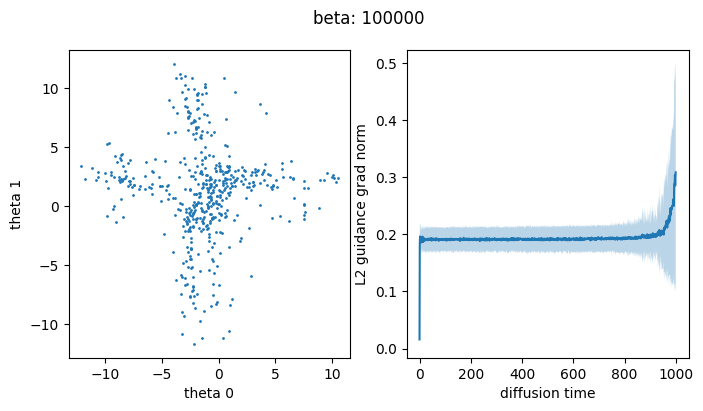

In [15]:
fig, axs = plt.subplots(ncols=2, figsize=(8, 4))

axs[0].scatter(*samples.detach().T, s=1)
axs[0].set_xlabel("theta 0")
axs[0].set_ylabel("theta 1")
grad_norms = torch.stack(guidance_grad).detach()
grad_norms_mean = grad_norms.mean(dim=1) 
grad_norms_std = grad_norms.std(dim=1) 
axs[1].plot(grad_norms_mean)
axs[1].fill_between(range(len(grad_norms_mean)), grad_norms_mean - grad_norms_std, grad_norms_mean + grad_norms_std, alpha=0.3)
axs[1].set_xlabel("diffusion time")
axs[1].set_ylabel("L2 guidance grad norm")
fig.suptitle(f"beta: {sampler.beta}")